In [318]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import precision_recall_curve, confusion_matrix,roc_curve, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, LassoCV,RidgeClassifier


In [247]:
SEED = 42
REPEATS = 5
FOLDS = 5

# EDA

In [248]:
d1 = pd.read_csv('/Users/paigegiese/SYG/wids-2025-mupd/data/TRAIN/TRAIN_CATEGORICAL_METADATA.csv')
d2 = pd.read_csv('/Users/paigegiese/SYG/wids-2025-mupd/data/TRAIN/TRAIN_QUANTITATIVE_METADATA.csv')
d3 = pd.read_csv('/Users/paigegiese/SYG/wids-2025-mupd/data/TEST/TEST_CATEGORICAL.csv')
d4 = pd.read_csv('/Users/paigegiese/SYG/wids-2025-mupd/data/TEST/TEST_QUANTITATIVE_METADATA.csv')
labels = pd.read_csv('/Users/paigegiese/SYG/wids-2025-mupd/data/TRAIN/TRAINING_SOLUTIONS.csv')
train_df = d1.merge(d2, on='participant_id').merge(labels, on='participant_id')
test_df = d3.merge(d4, on='participant_id')

test_df.describe()
test_df.set_index('participant_id', inplace=True)
train_df.set_index('participant_id', inplace=True)

# Dropping a few that we know are low val
train_df.drop(['PreInt_Demos_Fam_Child_Ethnicity', 'PreInt_Demos_Fam_Child_Race','Basic_Demos_Enroll_Year','Basic_Demos_Study_Site'], axis=1, inplace=True)

## Let's deal with missing age

In [249]:
train_df.shape[0]-360 == train_df.dropna().shape[0]

True

In [250]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

target_col = "MRI_Track_Age_at_Scan"  # Column to impute

# Impute missing values using IterativeImputer with Lasso
imputer = IterativeImputer(
    #estimator=LassoCV(random_state=SEED)
    max_iter=10, random_state=SEED)

imputer.fit(train_df.dropna(), y=target_col)



IterativeImputer(random_state=42)

In [251]:
train_df = pd.DataFrame(imputer.transform(train_df), columns=train_df.columns)

## Previously not done eda

### Cats

In [252]:
test_df['Barratt_Barratt_P1_Occ'].value_counts(normalize=True)

Barratt_Barratt_P1_Occ
45.0    0.270627
0.0     0.201320
35.0    0.151815
30.0    0.145215
40.0    0.145215
25.0    0.042904
15.0    0.029703
20.0    0.009901
5.0     0.003300
Name: proportion, dtype: float64

In [253]:
train_df['Barratt_Barratt_P1_Occ'].value_counts(normalize=True)

Barratt_Barratt_P1_Occ
0.0     0.261336
35.0    0.180544
45.0    0.154163
40.0    0.126958
30.0    0.126958
25.0    0.065128
15.0    0.028854
20.0    0.025556
5.0     0.025556
10.0    0.004946
Name: proportion, dtype: float64

In [254]:
train_df.head(1)
# Barratt_Barratt_P2_Edu

,MRI_Track_Scan_Location,Barratt_Barratt_P1_Edu,Barratt_Barratt_P1_Occ,Barratt_Barratt_P2_Edu,Barratt_Barratt_P2_Occ,EHQ_EHQ_Total,ColorVision_CV_Score,APQ_P_APQ_P_CP,APQ_P_APQ_P_ID,APQ_P_APQ_P_INV,...,SDQ_SDQ_Emotional_Problems,SDQ_SDQ_Externalizing,SDQ_SDQ_Generating_Impact,SDQ_SDQ_Hyperactivity,SDQ_SDQ_Internalizing,SDQ_SDQ_Peer_Problems,SDQ_SDQ_Prosocial,MRI_Track_Age_at_Scan,ADHD_Outcome,Sex_F
0,1.0,21.0,45.0,21.0,45.0,40.0,13.0,3.0,10.0,47.0,...,1.0,5.0,0.0,5.0,1.0,0.0,10.0,9.526267,1.0,1.0


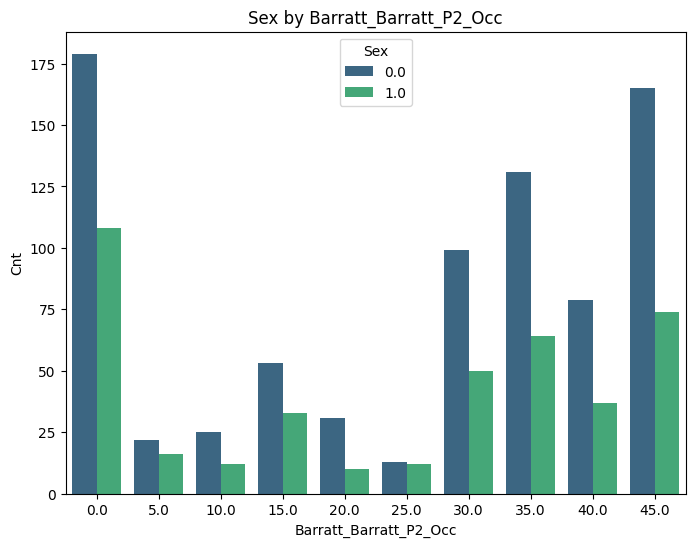

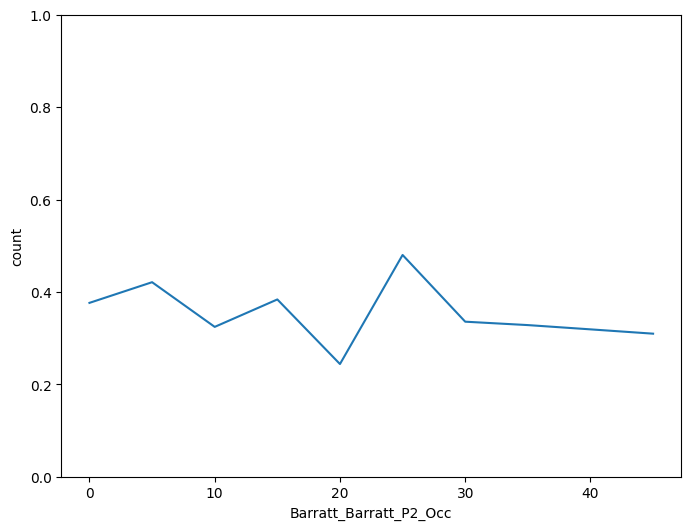

In [255]:
plt.figure(figsize=(8, 6))
col = 'Barratt_Barratt_P2_Occ'
pltd = train_df.value_counts([col,'Sex_F']).reset_index()
pct = (pltd[pltd['Sex_F']==1].groupby(col)['count'].max()/pltd.groupby(col)['count'].sum()).reset_index()
sns.barplot(x=col, y='count', hue='Sex_F', data=pltd, palette='viridis')



# Labels & Title
plt.xlabel(col)
plt.ylabel("Cnt")
plt.title(f"Sex by {col}")
plt.legend(title="Sex")

# Show Plot
plt.show()

plt.figure(figsize=(8, 6))
sns.lineplot(x = col, y = 'count', data=pct)
plt.ylim([0,1])
plt.show()

### EHQ

<Axes: >

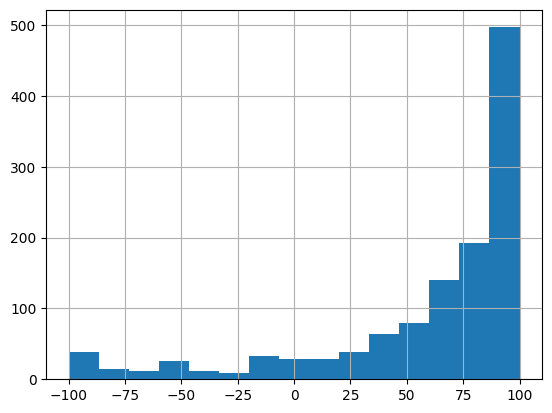

In [256]:
train_df['EHQ_EHQ_Total'].hist(bins=15)

<Axes: xlabel='ehq_bins'>

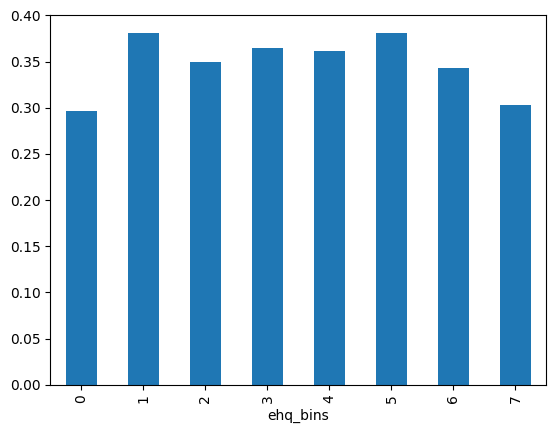

In [257]:
train_df['ehq_bins'] = pd.qcut(train_df['EHQ_EHQ_Total'], 10, duplicates='drop', labels=False)
train_df.groupby(['ehq_bins'])['Sex_F'].mean().plot.bar()

In [258]:
import scipy.stats as stats

for col in ['ehq_bins']:
    contingency_table = pd.crosstab(train_df[col], train_df['Sex_F'])  # Create contingency table
    chi2, p, dof, expected = stats.chi2_contingency(contingency_table)  # Run test

    print(f"Chi-Square Test for {col}:")
    print(f"Chi2 Statistic: {chi2:.4f}, p-value: {p:.4f}\n")

Chi-Square Test for ehq_bins:
Chi2 Statistic: 5.9969, p-value: 0.5401



In [259]:
from sklearn.preprocessing import StandardScaler
columns_to_scale = ['EHQ_EHQ_Total']  
scaler = StandardScaler()
train_df[columns_to_scale] = scaler.fit_transform(train_df[columns_to_scale])
correlations = train_df[['Sex_F','EHQ_EHQ_Total']].corr(method='spearman')
print(correlations['Sex_F'])

Sex_F            1.000000
EHQ_EHQ_Total   -0.027913
Name: Sex_F, dtype: float64


In [260]:
train_df['EHQ_EHQ_Total'].max()

0.8251856700610561

In [261]:
train_df.loc[train_df['EHQ_EHQ_Total']<= -28]

,MRI_Track_Scan_Location,Barratt_Barratt_P1_Edu,Barratt_Barratt_P1_Occ,Barratt_Barratt_P2_Edu,Barratt_Barratt_P2_Occ,EHQ_EHQ_Total,ColorVision_CV_Score,APQ_P_APQ_P_CP,APQ_P_APQ_P_ID,APQ_P_APQ_P_INV,...,SDQ_SDQ_Externalizing,SDQ_SDQ_Generating_Impact,SDQ_SDQ_Hyperactivity,SDQ_SDQ_Internalizing,SDQ_SDQ_Peer_Problems,SDQ_SDQ_Prosocial,MRI_Track_Age_at_Scan,ADHD_Outcome,Sex_F,ehq_bins


In [262]:
train_df['ehq_bin_dict']= None
train_df.loc[train_df['EHQ_EHQ_Total']<=-.28, 'ehq_bin_dict'] = 'left'
train_df.loc[(train_df['EHQ_EHQ_Total']> -.28)
             & (train_df['EHQ_EHQ_Total']<.48), 'ehq_bin_dict'] = 'middle'
train_df.loc[(train_df['EHQ_EHQ_Total']>=.48), 'ehq_bin_dict'] = 'right'

In [263]:
for col in ['ehq_bin_dict']:
    contingency_table = pd.crosstab(train_df[col], train_df['Sex_F'])  # Create contingency table
    chi2, p, dof, expected = stats.chi2_contingency(contingency_table)  # Run test

    print(f"Chi-Square Test for {col}:")
    print(f"Chi2 Statistic: {chi2:.4f}, p-value: {p:.4f}\n")

Chi-Square Test for ehq_bin_dict:
Chi2 Statistic: 2.1553, p-value: 0.3404



### scaling

<Axes: xlabel='ColorVision_CV_Score'>

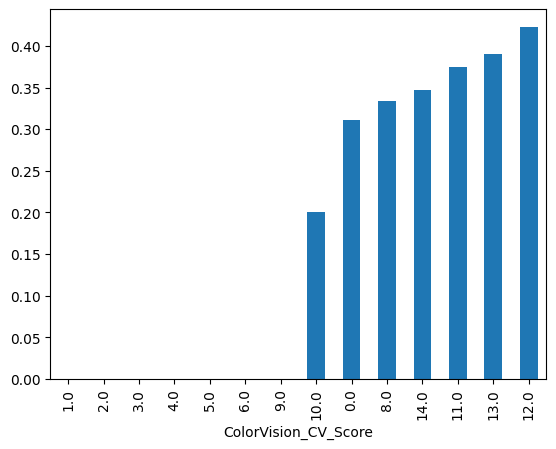

In [264]:
train_df.groupby('ColorVision_CV_Score')['Sex_F'].mean().sort_values().plot.bar()

In [265]:
from sklearn.preprocessing import StandardScaler
scale_cols = ['APQ_P_APQ_P_CP', 'APQ_P_APQ_P_ID', 'APQ_P_APQ_P_INV',
       'APQ_P_APQ_P_OPD', 'APQ_P_APQ_P_PM', 'APQ_P_APQ_P_PP',
       'SDQ_SDQ_Conduct_Problems', 'SDQ_SDQ_Difficulties_Total',
       'SDQ_SDQ_Emotional_Problems', 'SDQ_SDQ_Externalizing',
       'SDQ_SDQ_Generating_Impact', 'SDQ_SDQ_Hyperactivity',
       'SDQ_SDQ_Internalizing', 'SDQ_SDQ_Peer_Problems', 'SDQ_SDQ_Prosocial','ColorVision_CV_Score','MRI_Track_Age_at_Scan']

scaler = StandardScaler()
train_df[scale_cols] = scaler.fit_transform(train_df[scale_cols])

ord_cats = [
 'Barratt_Barratt_P1_Edu',
 'Barratt_Barratt_P1_Occ',
 'Barratt_Barratt_P2_Edu',
 'Barratt_Barratt_P2_Occ']

for c in ord_cats:
    train_df[c] = train_df[c].astype('str')

no_ord_cats =[
 'MRI_Track_Scan_Location'
]

for c in no_ord_cats:
    train_df[c] = train_df[c].astype('str')


train_df = pd.get_dummies(train_df, columns=['MRI_Track_Scan_Location'])
train_df.drop('MRI_Track_Scan_Location_1.0', axis=1, inplace=True)

In [266]:
mask_cols = ['EHQ_EHQ_Total','ehq_bins', 'ehq_bin_dict','ADHD_Outcome']
train_df.drop(mask_cols, axis=1, inplace=True)
target = 'Sex_F'



## identify interactions

In [267]:
for c in train_df:
    train_df[c] = train_df[c].astype(float)

In [278]:
from itertools import combinations
# Select continuous features
continuous_features = ['Barratt_Barratt_P1_Edu', 'Barratt_Barratt_P1_Occ',
       'Barratt_Barratt_P2_Edu', 'Barratt_Barratt_P2_Occ','APQ_P_APQ_P_CP', 'APQ_P_APQ_P_ID',
       'APQ_P_APQ_P_INV', 'APQ_P_APQ_P_OPD', 'APQ_P_APQ_P_PM',
       'APQ_P_APQ_P_PP', 'SDQ_SDQ_Conduct_Problems',
       'SDQ_SDQ_Difficulties_Total', 'SDQ_SDQ_Emotional_Problems',
       'SDQ_SDQ_Externalizing', 'SDQ_SDQ_Generating_Impact',
       'SDQ_SDQ_Hyperactivity', 'SDQ_SDQ_Internalizing',
       'SDQ_SDQ_Peer_Problems', 'SDQ_SDQ_Prosocial', 'MRI_Track_Age_at_Scan',
       'MRI_Track_Scan_Location_0.0', 'MRI_Track_Scan_Location_2.0',
       'MRI_Track_Scan_Location_3.0', 'MRI_Track_Scan_Location_4.0']  

# Generate interaction terms (pairwise multiplication)
interaction_terms = {}

# for f1, f2 in combinations(continuous_features, 2):
#     #interaction_terms[f'{f1}*{f2}'] = 
#     print(train_df[f1] * train_df[f2])

for f1, f2 in combinations(continuous_features, 2):
    name = f'{f1}*{f2}'
    vals = (train_df[f1] * train_df[f2]).values
    interaction_terms.update({name: vals})

In [282]:
itx = pd.DataFrame(interaction_terms)

train_df_2 = train_df.merge(itx, how='left', left_index=True, right_index=True)

In [284]:
from xgboost import XGBClassifier

# Train model with interaction terms
xgb = XGBClassifier()
xgb.fit(itx, train_df['Sex_F'].values)

# Get feature importances
feature_importances = pd.Series(xgb.feature_importances_, index=itx.columns)
print(feature_importances.sort_values(ascending=False))[:20]


SDQ_SDQ_Emotional_Problems*MRI_Track_Scan_Location_3.0     0.021604
Barratt_Barratt_P2_Occ*MRI_Track_Scan_Location_3.0         0.020358
SDQ_SDQ_Difficulties_Total*MRI_Track_Scan_Location_3.0     0.014718
Barratt_Barratt_P1_Occ*MRI_Track_Scan_Location_3.0         0.014544
Barratt_Barratt_P1_Occ*Barratt_Barratt_P2_Occ              0.013763
                                                             ...   
SDQ_SDQ_Externalizing*MRI_Track_Scan_Location_3.0          0.000000
SDQ_SDQ_Externalizing*MRI_Track_Scan_Location_4.0          0.000000
Barratt_Barratt_P1_Occ*MRI_Track_Scan_Location_2.0         0.000000
Barratt_Barratt_P1_Occ*MRI_Track_Scan_Location_0.0         0.000000
MRI_Track_Scan_Location_3.0*MRI_Track_Scan_Location_4.0    0.000000
Length: 276, dtype: float32


<Axes: >

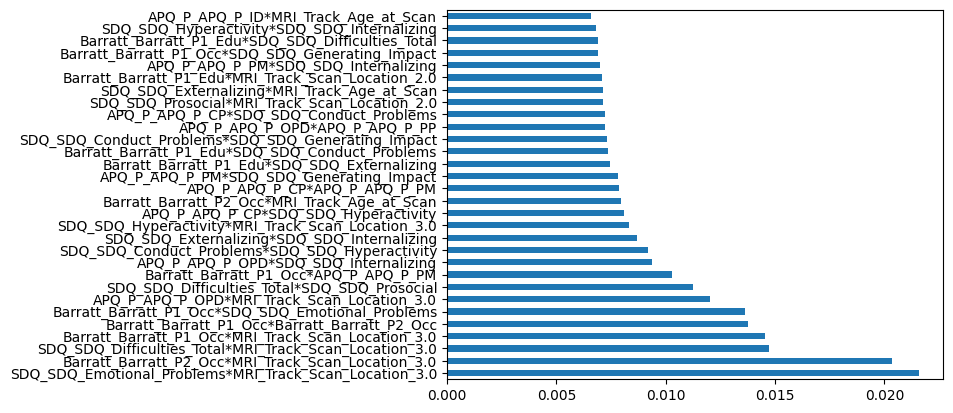

In [289]:
feature_importances.sort_values(ascending=False)[:30].plot.barh()

In [309]:
keep_itx = feature_importances[feature_importances>=.01].index.tolist()

<Axes: >

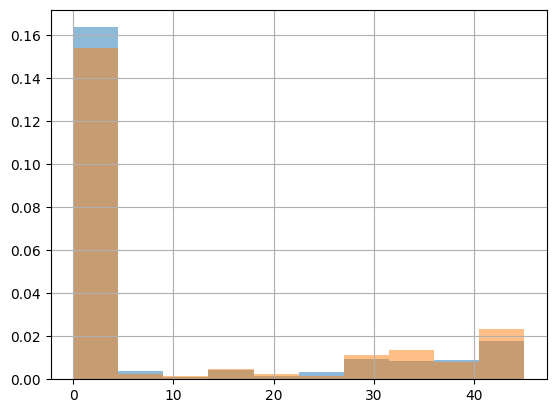

In [308]:
train_df_2[train_df_2['Sex_F'] ==1]['Barratt_Barratt_P2_Occ*MRI_Track_Scan_Location_3.0'].hist(alpha=.5, density=True)
train_df_2[train_df_2['Sex_F'] ==0]['Barratt_Barratt_P2_Occ*MRI_Track_Scan_Location_3.0'].hist(alpha=.5, density=True)

In [313]:
for c in itx.columns.tolist():
    if c not in keep_itx:
        train_df_2.drop(c, axis=1, inplace=True)

In [355]:
train_df_3= train_df_2.copy()
for c in train_df_2.columns:
    if 'Location' in c:
        train_df_3.drop(c, axis=1, inplace=True)
train_df_3


,Barratt_Barratt_P1_Edu,Barratt_Barratt_P1_Occ,Barratt_Barratt_P2_Edu,Barratt_Barratt_P2_Occ,ColorVision_CV_Score,APQ_P_APQ_P_CP,APQ_P_APQ_P_ID,APQ_P_APQ_P_INV,APQ_P_APQ_P_OPD,APQ_P_APQ_P_PM,...,SDQ_SDQ_Hyperactivity,SDQ_SDQ_Internalizing,SDQ_SDQ_Peer_Problems,SDQ_SDQ_Prosocial,MRI_Track_Age_at_Scan,Sex_F,Barratt_Barratt_P1_Occ*Barratt_Barratt_P2_Occ,Barratt_Barratt_P1_Occ*APQ_P_APQ_P_PM,Barratt_Barratt_P1_Occ*SDQ_SDQ_Emotional_Problems,SDQ_SDQ_Difficulties_Total*SDQ_SDQ_Prosocial
0,21.0,45.0,21.0,45.0,-0.059321,-0.567920,-0.841235,1.221414,-1.271915,-1.003435,...,-0.175603,-1.013461,-1.080633,1.058089,-0.580147,1.0,2025.0,-45.154577,-27.155954,-0.985399
1,15.0,15.0,0.0,0.0,0.300459,-0.567920,-0.053875,-0.860800,0.056968,1.229216,...,0.882376,1.544678,0.833653,-1.225651,1.053058,0.0,0.0,18.438234,25.563581,-1.095651
2,18.0,40.0,0.0,0.0,0.300459,0.158754,-0.841235,-0.700630,-0.474585,-1.189489,...,0.529716,0.407728,0.833653,0.601341,-1.023462,0.0,0.0,-47.579570,-5.676991,0.171696
3,15.0,30.0,18.0,0.0,-1.138660,0.885428,-0.316329,-0.059948,0.322744,-0.073164,...,1.587695,0.976203,0.833653,-0.768903,-0.299751,1.0,0.0,-2.194918,23.434709,-1.389063
4,15.0,20.0,0.0,0.0,0.300459,0.885428,0.471031,0.100222,0.588521,1.415270,...,1.587695,0.691965,0.355082,0.601341,-0.781956,1.0,0.0,28.305396,15.623139,0.537559
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1208,21.0,40.0,21.0,40.0,0.300459,0.885428,0.208578,-0.059948,0.588521,-0.259218,...,0.177057,-0.729223,-1.080633,0.601341,-0.176363,0.0,1600.0,-10.368726,-5.676991,-0.285632
1209,18.0,35.0,0.0,0.0,0.300459,-0.567920,-0.841235,-1.181141,0.588521,-1.003435,...,-0.175603,0.691965,0.833653,-0.312155,0.949473,1.0,0.0,-35.120226,11.186563,-0.279046
1210,18.0,20.0,0.0,0.0,0.300459,-0.567920,0.733485,-1.821822,-0.740362,0.484999,...,-1.938902,-1.013461,-1.080633,1.058089,0.294632,1.0,0.0,9.699974,-12.069313,-1.307276
1211,21.0,40.0,18.0,45.0,0.300459,-0.567920,0.208578,-0.860800,0.056968,1.229216,...,-0.175603,-1.297698,-1.080633,0.601341,0.303072,0.0,1800.0,49.168624,-42.600260,-0.285632


In [365]:
# Example dataset (Replace with actual data)
X = train_df_2.drop(columns=["Sex_F"])  # Features
y = train_df_2["Sex_F"]  # Binary Target

# Define models
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
xgb_model = XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric="logloss", random_state=42)
ridge_logistic = LogisticRegression(penalty='l2', C=1.0, solver='lbfgs', random_state=42)

# # Create ensemble model
# voting_model = VotingClassifier(
#     estimators=[("rf", rf_model), ("xgb", xgb_model), ("ridge", ridge_logistic)],
#     voting="soft"  # Use soft voting to get probabilities
# )


# Split once for multiple y variables
X_train, X_test, y1_train, y1_test = train_test_split(
    X, y, test_size=0.15, random_state=42
)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y1_train)

ridge_logistic = LogisticRegression(penalty='l2', C=1.0, solver='saga', random_state=42)
ridge_logistic.fit(X_train, y1_train)

xgb_model = XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric="logloss", random_state=42)
xgb_model.fit(X_train, y1_train)



/Users/paigegiese/SYG/wids-2025-mupd/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=6,
              max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, ...)

In [368]:
#y_preds = rf_model.predict_proba(X_test)[:,1]
#y_preds = ridge_logistic.predict_proba(X_test)[:,1]
y_preds = xgb_model.predict_proba(X_test)[:,1]
output = pd.DataFrame(list(zip(y1_test, y_preds)), columns=['actual','predicted'])
for thresh in np.arange(0.15,.7,.15):
    print(f'F1 {thresh}')
    print(f1_score(output['actual'].values,np.where(output['predicted']>=thresh,1,0)))

F1 0.15
0.41025641025641024
F1 0.3
0.40336134453781514
F1 0.44999999999999996
0.40404040404040403
F1 0.6
0.3855421686746988


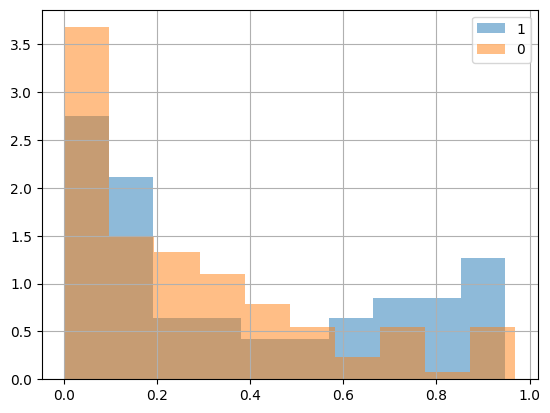

In [369]:
output[output['actual']==1]['predicted'].hist(alpha=.5, density=True, label='1')
output[output['actual']==0]['predicted'].hist(alpha=.5, density=True, label='0')
plt.legend();